# Credit Risk and Interest Rate Modeling Notebook

This notebook explores advanced topics in fixed income and credit risk modeling. It covers the construction and interpolation of yield curves using cubic splines, pricing of zero-coupon bonds, and the calculation of portfolio sensitivities such as duration and convexity. The notebook also compares the Vasicek and CIR interest rate models, including their impact on bond prices and yields.

Further sections address convexity adjustments for derivatives, quanto adjustments for cross-currency swaps, and the pricing and risk analysis of credit tranches using binomial models. The final problems simulate correlated default times for a portfolio of credits, providing summary statistics and visualizations for maximum, mean, and minimum time to default.

Throughout, the notebook combines mathematical derivations, Python implementations, and graphical analysis to provide a comprehensive view of modern credit and interest rate risk management techniques.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import norm, binom
from scipy.special import ndtri
from sympy import symbols, Eq, solve
from sympy.abc import x,y,z

## Problem 1
a.
<br>
The yield  of a 2 year zero coupon bond with cubic spline interpolation is 4.911%.
<br>
<br>
b.
<br>
You will go long 1.04319914410360 6 month zero coupon bonds, while shorting 1.88605821059907 1 year zero coupon bonds and 0.158885340363181 4 year zero coupon bonds. This funds the purchase of one 2 year zero coupon bond while leaving the portfolio of bonds insensitive to 1st and 2nd order change in yield.

In [2]:
def cubic_spline_coeff(maturities, yields):
    t= maturities
    
    n = len(yields)
    A = np.zeros((n+2,n+2)) 
    rates = np.append(yields , [0,0])
    ## j = col, i = row
    for i in range(n):
        for j in range(n+2):
            if j == 0:
                A[i,j] = 1
            elif j==1:
                A[i,j] = (t[i]-t[0])
            elif j==2:
                A[i,j] = (t[i]-t[0])**2
            else:
                A[i,j]= max((t[i]-t[j-3]),0)**3
                
    for i in range(n,n+2):
        for j in range(n+2):
            if j==2:
                A[i,j] = 2
            elif j>2 and i == n+1:
                A[i,j] = 6*(t[n-1]-t[j-3])
                
    coeff = np.linalg.solve(A, rates)
    
    return A, rates, coeff

def estimate_yield_rate(a, b, c, ds, t, maturities):
    cube_term = 0
    for i in range(len(ds)):
        add = ds[i]*max((t-maturities[i])**3,0)
        cube_term = cube_term + add
    
    r = a + b*(t-maturities[0]) + c*((t-maturities[0])**2) + cube_term
    return r


def bond_price(y,t_maturity, face):
    return face/((y+1)**t_maturity)

In [3]:
maturities = np.array([.5, 1, 4])  # Maturities in years
yields = np.array([.0543, .0520, .0480])  # Corresponding yields

coeff = cubic_spline_coeff(maturities, yields)[2] 
a = coeff[0]
b = coeff[1]
c = coeff[2]
ds = coeff[3:]

In [4]:
t = 2
y_2 = estimate_yield_rate(a, b, c, ds, t, maturities)
print('The yield of a zero coupon bond at t=2 is '+str(round(y_2*100,3))+ '%')

The yield of a zero coupon bond at t=2 is 4.911%


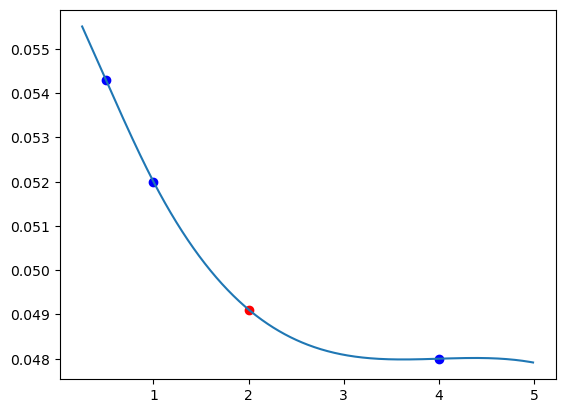

In [5]:
ts = np.arange(.25, 5, .01)
yield_curve = []
for t in ts:
    y = estimate_yield_rate(a, b, c, ds, t, maturities)
    yield_curve.append(y)
plt.scatter(maturities, yields, color='blue')
plt.scatter(2,estimate_yield_rate(a, b, c, ds, 2, maturities), color = 'red')
plt.plot(ts, yield_curve)
plt.show()

In [6]:
B_half = bond_price(yields[0],maturities[0], 1)
B_1 = bond_price(yields[1],maturities[1], 1)
B_2 = bond_price(y_2,2, 1)
B_4 = bond_price(yields[2],maturities[2], 1)

In [7]:
prices = [B_half,B_1,B_2,B_4]
mats = [.5,1,2,4]
yields = [.0543,.052,y_2,.048]

In [8]:
durations = mats
convexities = []
for i in range(len(mats)):
    convexity = (mats[i]**2+mats[i])/((1+yields[i])**(mats[i]+2))
    convexities.append(convexity)
convexities

[0.6571291716982496, 1.717840257567196, 4.952965509758235, 15.096014342635486]

In [9]:
from sympy import symbols, Eq, solve
from sympy.abc import x,y,z
equations = [x*durations[0] + y*durations[1] +z*durations[3] + durations[2] , 
             x*convexities[0] + y*convexities[1] +z*convexities[3] + convexities[2],
             x*prices[0] + y*prices[1] +z*prices[3] + prices[2]]
solutions = solve(equations, x, y, z)
solutions

{x: 1.04319914410360, y: -1.88605821059907, z: -0.158885340363181}

## Problem 2

In the table below there shows the prices of a 1 dollar bond with the Vasicek and CIR interest rate models. It also provides the yields for each model. We also have graphs comparing the models below.
<br>
<br>
a.
<br>
The Vasicek and CIR model are very similar, but as the maturity increases, the prices diverge slightly with the CIR model providing a lower price than the Vasicek model. 
<br>
<br>
b.
<br>
The yield of the models diverge relatively soon with the CIR model providing a much more consistent(flatter) yield curve than the Vasicek model. The Vasicek model's yield decreases much quicker than the CIR yield curve.

In [10]:
def Vasicek_bond_price(a,b,sigma,r,T,t):
    r_t = r
    sig= sigma
    B_t_T = (1-np.exp(-a*(T-t)))/a
    A_t_T = np.exp(((B_t_T-T+t)*((a**2)*b-(sig**2)/2))/(a**2) - (sig**2)*(B_t_T**2)/(4*a))
    Price = A_t_T*np.exp(-B_t_T*r_t)
    return Price
    
def CIR_bond_price(a,b,sigma,r,T,t):
    r_t = r
    sig = sigma
    gamma = np.sqrt(a**2+2*(sig**2))
    gamma_exp = np.exp(gamma*(T-t))-1
    B_t_T = 2*gamma_exp/((gamma+a)*gamma_exp +2*gamma)
    A_t_T = (2*gamma*np.exp((a+gamma)*(T-t)/2)/((gamma+a)*gamma_exp +2*gamma))**(2*a*b/(sig)**2)
    Price = A_t_T*np.exp(-B_t_T*r_t)
    return Price

def bond_yield(price, t):
    return (1/price)**(1/t)-1

In [11]:
Ts= [2,4,6,8,10]
t=0
a=.1
b=.1
sigma = .02
r= .1
V_prices =[]
C_prices = []
V_yields = []
C_yields = []
for T in Ts:
    v_p = Vasicek_bond_price(a,b,sigma,r,T,t)
    c_p = CIR_bond_price(a,b,sigma,r,T,t)
    V_prices.append(v_p)
    C_prices.append(c_p)
    v_y= bond_yield(v_p,T)
    c_y = bond_yield(c_p,T)
    V_yields.append(v_y)
    C_yields.append(c_y)
d = {'Vasicek Prices': V_prices, 'CIR Prices': C_prices, 'Vasicek Yields': V_yields, 'CIR Yields': C_yields}
z_coup_p_df = pd.DataFrame(d, index = Ts)
z_coup_p_df

,Vasicek Prices,CIR Prices,Vasicek Yields,CIR Yields
2,0.819108,0.818768,0.104917,0.105145
4,0.672465,0.670534,0.104288,0.105083
6,0.553998,0.549327,0.103440,0.104998
8,0.458196,0.450205,0.102475,0.104902
10,0.380457,0.369112,0.101462,0.104801


In [12]:
T_s = np.arange(0.01,10.01,.01)
V_prices =[]
C_prices = []
V_yields = []
C_yields = []
for T in T_s:
    v_p = Vasicek_bond_price(a,b,sigma,r,T,t)
    c_p = CIR_bond_price(a,b,sigma,r,T,t)
    V_prices.append(v_p)
    C_prices.append(c_p)
    v_y= bond_yield(v_p,T)
    c_y = bond_yield(c_p,T)
    V_yields.append(v_y)
    C_yields.append(c_y)

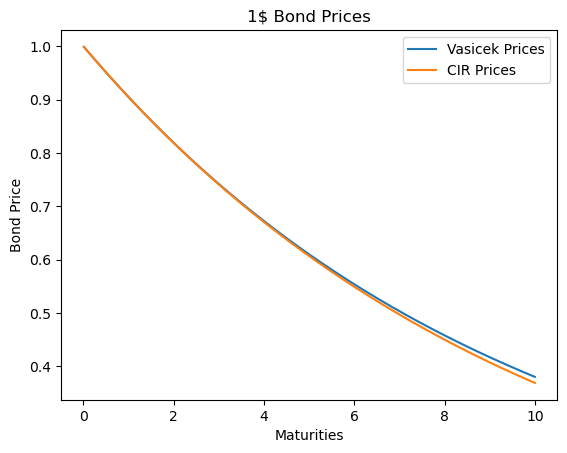

In [13]:
plt.plot(T_s, V_prices, label = 'Vasicek Prices')
plt.plot(T_s, C_prices, label = 'CIR Prices')
plt.legend()
plt.title("1$ Bond Prices")
plt.xlabel('Maturities')
plt.ylabel('Bond Price')
plt.show()

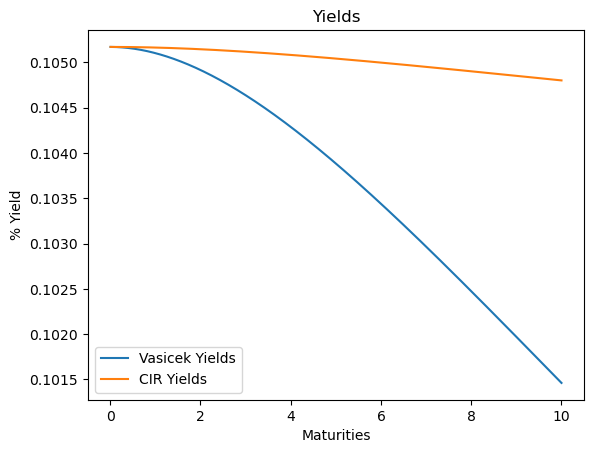

In [14]:
plt.plot(T_s, V_yields, label= 'Vasicek Yields')
plt.plot(T_s, C_yields, label= 'CIR Yields')
plt.legend()
plt.title('Yields')
plt.xlabel('Maturities')
plt.ylabel('% Yield')
plt.show()

## Problem 3

a.
c = .045/2 = .0225
\begin{equation}
G(y)= \Sigma_{i=1}^{6} \frac{.0225}{(1+\frac{y}{2})^i} + \frac{1}{(1+\frac{y}{2})^6}
\end{equation}

\begin{equation}
G'(y)=  \Sigma_{i=1}^{6} \frac{-\frac{.0225}{2}*i}{(1+\frac{y}{2})^{i+1}} - \frac{\frac{1}{2}*6}{(1+\frac{y}{2})^7}
\end{equation}

\begin{equation}
G''(y)=  \Sigma_{i=1}^{6} \frac{\frac{.0225}{4}*i*(i+1)}{(1+\frac{y}{2})^{i+2}} + \frac{\frac{1}{4}*6*7}{(1+\frac{y}{2})^8}
\end{equation}

\begin{equation}
adjustment = y - .5*y^{2}\sigma_{y}^{2}T\frac{G''(y)}{G'(y)}
\end{equation}

\begin{equation}
Value = \frac{adjustment*L}{(1+r_{US}/2)^{2T}}
\end{equation}
where T=8, y= .045, $\sigma_{y}$ = .2, L = 2000000, $r_{US}$ = .042
<br>
<br>
The value of the derivative if the swap rate is applied to 2,000,000 dollars is 66,101.39

In [15]:
#Convexity adjustment
def g_y(c, y, t, n):
    periods = t*n
    g = 1/((1+y/n)**periods)
    for i in range(periods):
        g = g + (c/2)/((1+y/n)**(i+1))
    return g


def g_prime(c, y, t, n):
    periods = t*n
    g_p = -3/((1+y/n)**(periods+1))
    for i in range(periods):
        g_p = g_p - ((i+1)*c/4)/((1+y/n)**(i+2))
    return g_p


def g_double_prime(c, y, t, n):
    periods = t*n
    g_dp = (1.5*7)/((1+y/n)**(periods+2))
    for i in range(periods):
        g_dp = g_dp + ((i+2)*(i+1)*c/8)/((1+y/n)**(i+3))
    return g_dp


def adjustment(c, y, t, n, sig_y, T):
    adj_rate = y - .5*(y**2)*(sig_y**2)*T*g_double_prime(c, y, t, n)/g_prime(c, y, t, n)
    return adj_rate

In [16]:
t = 3
n = 2
c= .045
y= .045
sig_y = .2
T = 8
r= .042
L= 2000000

In [17]:
adj_rate = adjustment(c, y, t, n, sig_y, T)
adj_rate

0.046088488597977276

In [18]:
adj_rate*L/((1+(r/2))**(T*2))

66101.38947427605

Part b.
<br>
vol =.2 for fwd swap, vol .1 for Yen/Dollar, corr .4 exchange and U.S dollar ir, 
X = Dollar,
Y= Yen,
L = Principal = 2000000,
$r_{yen}$ = .004
\begin{equation}
E_{X}(V_{T}) = E_{Y}(V_{T})e^{\rho_{vw}\sigma_{v}\sigma_{w}T}
\end{equation}
\begin{equation}
E_{Y}(V_{T}) = \frac{E_{X}(V_{T})}{e^{\rho_{vw}\sigma_{v}\sigma_{w}T}}
\end{equation}
\begin{equation}
Value = \frac{E_{Y}(V_{T})*L}{(1+r_{yen}/2)^{2T}}
\end{equation}

So the value of the derivative is 83,742.14 Yen

In [19]:
E_X = adj_rate
vol_v= .2
vol_w = .1
corr_vw= .4 
T=8
L=2000000
r= .004
def quanto_adjustment(corr_vw, vol_v, vol_w, T):
    quanto_adj = np.exp(vol_v*vol_w*corr_vw*T)
    return quanto_adj

In [20]:
quanto_adj = quanto_adjustment(corr_vw, vol_v, vol_w, T)
quanto_adj

1.0660923987615052

In [21]:
E_Y = adj_rate/quanto_adj
(E_Y*L)/((1+r/2)**(T*2))

83742.1430306788

## Problem 4 

a.
<br>

The probability that the senior tranche is wiped out is 0, the probability that the mezzanine tranche is wiped out is 54.278%, and the probability that the equity tranche is wiped out is 99.957%.

<br>
<br>
b.
<br>
The price of the equity tranche is 535.20 dollars, the price of the mezzanine tranche is 1,415,874.53 dollars, and the price of the senior tranche is 83,583,590.27 dollars.

In [22]:
from scipy.stats import norm, binom
n = 100
p= .15
tranches = np.array([5,10,85])
num_defs_needed = tranches.cumsum()
pds =[]
for defs in num_defs_needed:
    pd = 1 - binom.cdf(defs-1,n,p)
    pds.append(pd)
pds

[0.9995744861829607, 0.542775794224051, 0.0]

In [23]:
#equity tranche
eq_val = 0
for i in range(tranches[0]+1):
    value = (tranches[0]-i)
    prob = binom.pmf(i,n,p)
    EV = value*prob
    eq_val = eq_val +EV
round(eq_val*1000000,2)

535.2

In [24]:
#mezzanine tranche
mezz_val = binom.cdf(4,n,p)*tranches[1]
for i in range(tranches[1]+1):
    value = (tranches[1]-i)
    prob = binom.pmf(i+5,n,p)
    EV = value*prob
    mezz_val = mezz_val +EV
round(mezz_val*1000000,2)

1415874.53

In [25]:
#senior tranche
sen_val = binom.cdf(14,n,p)*tranches[2]
for i in range(tranches[2]+1):
    value = (tranches[2]-i)
    prob = binom.pmf(i+15,n,p)
    EV = value*prob
    sen_val = sen_val +EV
round(sen_val*1000000,2)

83583590.27

In [26]:
eq_val+mezz_val+sen_val

84.99999999999986

## Problem 5

The Hazard Rate $\lambda$ is 3.46% and the Recovery Rate R is 22.2194% as shown in the Excel Sheet.

## Problem 6

b. 
<br>
The summary statistics for each of the 10 credits is provided below. We can see the first 5 provide much different results than the last 5. It makes sense the first 5 have a longer time to default because of the lower hazard rate.
<br>
<br>
c.
<br>
We can see the pdf of the combined and then also of the two sets. The 1st set has a lower mean because of the lower hazard rate and it also has a fatter tail because of the negative correlation. The 2nd set has a lower mean time to default because of the higher hazard rate and due to the positive correlation with the second variable they are more likely to default together lowering the max default times making narrower tails.

In [27]:
import pandas as pd
def latent_var_sim(b_1, b_2s, hazs, t, n, sims):
    C_Ts= [] 
    b_2j,b_2k = b_2s 
    haz_j, haz_k = hazs   
    '''
    for j in range(n): 
        if j < n/2:
            Q_T = np.exp(-haz_j*T)
        else:
            Q_T = np.exp(-haz_k*T)  
        CPD = 1-Q_T
        C_T = ndtri(CPD)
        C_Ts.append(C_T)
    '''
    rvs = np.random.standard_normal((2+n,sims))
    z_1 = rvs[0]
    z_2 = rvs[1]
    eps = rvs[2:]
    A_s = []
    u_s = []
    default_times = []
    means = []
    medians = []
    mins = []
    maxs = []
    quartile_1s= []
    quartile_3s = []
    
    for j in range(n):
        if j < n/2:
            A_n = b_1*z_1+b_2j*z_2+(np.sqrt(1-(b_1**2)-(b_2j**2))*eps[j])
            u_n = 1 - norm.cdf(A_n)
            Q_inv = np.log(u_n)/(-haz_j)
        else:
            A_n = b_1*z_1+b_2k*z_2+(np.sqrt(1-(b_1**2)-(b_2k**2))*eps[j])
            u_n = 1 - norm.cdf(A_n)
            Q_inv = np.log(u_n)/(-haz_k)
        A_s.append(A_n)
        u_s.append(u_n)
        default_times.append(Q_inv)
        means.append(np.mean(Q_inv))
        medians.append(np.median(Q_inv))
        mins.append(np.min(Q_inv))
        maxs.append(np.max(Q_inv))
        quartile_1s.append(np.quantile(Q_inv,.25))
        quartile_3s.append(np.quantile(Q_inv,.75))
    col = [ 'Minimum', '1st Quartile','Mean', 'Median', '3rd Quartile','Maximum']
    summary_df = pd.DataFrame(np.array([mins,quartile_1s,
                                        means,medians,
                                        quartile_3s,maxs]).T,
                              index = np.arange(1,n+1), columns = col)
    
    return np.array(default_times), summary_df

In [28]:
b_1 = .15
b_2s =[-.6,.4]
hazs =[.01,.02]
n = 10
sims = 10000
T= 30
res = latent_var_sim(b_1, b_2s, hazs, T, n, sims)
res[1]

,Minimum,1st Quartile,Mean,Median,3rd Quartile,Maximum
1,0.000231,27.979175,99.736056,67.966970,138.910399,798.609515
2,0.000163,28.892144,99.478904,69.598139,136.794525,1045.315134
3,0.000624,29.383958,100.087522,69.356884,138.305953,1057.016586
4,0.001235,28.504024,98.204308,68.153987,136.865291,873.523721
5,0.004674,28.587879,97.862413,68.528302,136.121508,789.649979
6,0.004867,13.966138,50.147566,34.285731,69.975289,464.326257
7,0.005251,14.018637,50.107153,34.188946,69.564246,442.683923
8,0.007002,14.643712,49.971633,34.541025,68.681120,519.274209
9,0.013086,14.180312,49.599554,34.701008,68.770376,494.816998
10,0.004823,14.643441,50.427476,34.421819,69.185991,556.475989


In [29]:
port_def_ts = []
port_def_js = []
port_def_ks = []
for i in range(sims):
    default_t = np.max(res[0].T[i])
    default_j = np.max(res[0].T[i][:5])
    default_k = np.max(res[0].T[i][5:])
    port_def_ts.append(default_t)
    port_def_js.append(default_j)
    port_def_ks.append(default_k)


In [30]:
percent_comb_port_less_50 = np.where(port_def_ts < np.ones(sims)*50,1,0).cumsum()[-1]/sims
percent_1_port_less_50 = np.where(port_def_js < np.ones(sims)*50,1,0).cumsum()[-1]/sims
percent_2_port_less_50 = np.where(port_def_ks < np.ones(sims)*50,1,0).cumsum()[-1]/sims
percent_comb_port_less_100 = np.where(port_def_ts < np.ones(sims)*100,1,0).cumsum()[-1]/sims
percent_1_port_less_100 = np.where(port_def_js < np.ones(sims)*100,1,0).cumsum()[-1]/sims
percent_2_port_less_100 = np.where(port_def_ks < np.ones(sims)*100,1,0).cumsum()[-1]/sims
percent_comb_port_less_150 = np.where(port_def_ts < np.ones(sims)*150,1,0).cumsum()[-1]/sims
percent_1_port_less_150 = np.where(port_def_js < np.ones(sims)*150,1,0).cumsum()[-1]/sims
percent_2_port_less_150 = np.where(port_def_ks < np.ones(sims)*150,1,0).cumsum()[-1]/sims
percent_comb_port_less_200 = np.where(port_def_ts < np.ones(sims)*200,1,0).cumsum()[-1]/sims
percent_1_port_less_200 = np.where(port_def_js < np.ones(sims)*200,1,0).cumsum()[-1]/sims
percent_2_port_less_200 = np.where(port_def_ks < np.ones(sims)*200,1,0).cumsum()[-1]/sims
percent_comb_port_less_250 = np.where(port_def_ts < np.ones(sims)*250,1,0).cumsum()[-1]/sims
percent_1_port_less_250 = np.where(port_def_js < np.ones(sims)*250,1,0).cumsum()[-1]/sims
percent_2_port_less_250 = np.where(port_def_ks < np.ones(sims)*250,1,0).cumsum()[-1]/sims
percent_comb_port_less_300 = np.where(port_def_ts < np.ones(sims)*300,1,0).cumsum()[-1]/sims
percent_1_port_less_300 = np.where(port_def_js < np.ones(sims)*300,1,0).cumsum()[-1]/sims
percent_2_port_less_300 = np.where(port_def_ks < np.ones(sims)*300,1,0).cumsum()[-1]/sims
percent_comb_port_less_350 = np.where(port_def_ts < np.ones(sims)*350,1,0).cumsum()[-1]/sims
percent_1_port_less_350 = np.where(port_def_js < np.ones(sims)*350,1,0).cumsum()[-1]/sims
percent_2_port_less_350 = np.where(port_def_ks < np.ones(sims)*350,1,0).cumsum()[-1]/sims
percent_comb_port_less_400 = np.where(port_def_ts < np.ones(sims)*400,1,0).cumsum()[-1]/sims
percent_1_port_less_400 = np.where(port_def_js < np.ones(sims)*400,1,0).cumsum()[-1]/sims
percent_2_port_less_400 = np.where(port_def_ks < np.ones(sims)*400,1,0).cumsum()[-1]/sims

In [31]:
import pandas as pd
#Maximum time to default cummulative probabilities
d = {'Cum Prob DT less than 50': [percent_comb_port_less_50, percent_1_port_less_50, percent_2_port_less_50], 
     'Cum Prob DT less than 100': [percent_comb_port_less_100, percent_1_port_less_100, percent_2_port_less_100], 
     'Cum Prob DT less than 150': [percent_comb_port_less_150, percent_1_port_less_150, percent_2_port_less_150], 
     'Cum Prob DT less than 200': [percent_comb_port_less_200, percent_1_port_less_200, percent_2_port_less_200], 
     'Cum Prob DT less than 250': [percent_comb_port_less_250, percent_1_port_less_250, percent_2_port_less_250], 
     'Cum Prob DT less than 300': [percent_comb_port_less_300, percent_1_port_less_300, percent_2_port_less_300],
     'Cum Prob DT less than 350': [percent_comb_port_less_350, percent_1_port_less_350, percent_2_port_less_350], 
     'Cum Prob DT less than 400': [percent_comb_port_less_400, percent_1_port_less_400, percent_2_port_less_400]}
table = pd.DataFrame(d, index=['Combined', 'Credits 1-5','Credits 6-10'])
table

,Cum Prob DT less than 50,Cum Prob DT less than 100,Cum Prob DT less than 150,Cum Prob DT less than 200,Cum Prob DT less than 250,Cum Prob DT less than 300,Cum Prob DT less than 350,Cum Prob DT less than 400
Combined,0.0014,0.0825,0.3041,0.5309,0.6968,0.8063,0.8772,0.9236
Credits 1-5,0.0681,0.2450,0.4362,0.6033,0.7293,0.8188,0.8826,0.9258
Credits 6-10,0.1670,0.5411,0.7900,0.9116,0.9643,0.9869,0.9946,0.9978


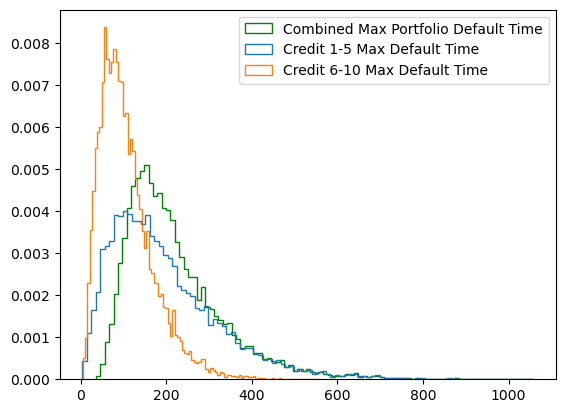

In [32]:
plt.hist(port_def_ts, bins = 100,density= True,stacked = True, histtype='step', label = 'Combined Max Portfolio Default Time', color= 'green')
plt.hist(port_def_js, bins = 100,density= True,stacked = True, histtype='step', label = 'Credit 1-5 Max Default Time')
plt.hist(port_def_ks, bins = 100,density= True,stacked = True, histtype='step', label = 'Credit 6-10 Max Default Time' )
plt.legend()
plt.show()

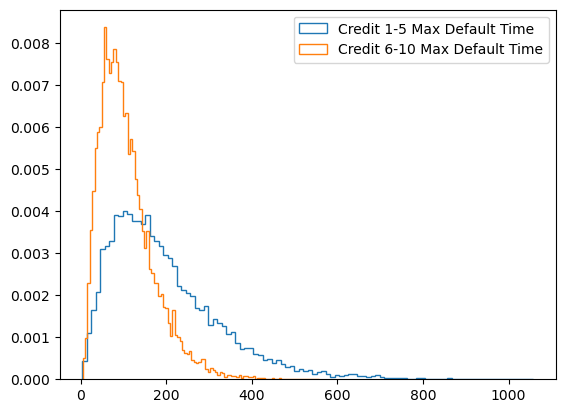

In [33]:
plt.hist(port_def_js, bins = 100,density= True,stacked = True, histtype='step', label = 'Credit 1-5 Max Default Time')
plt.hist(port_def_ks, bins = 100,density= True,stacked = True, histtype='step', label = 'Credit 6-10 Max Default Time' )
plt.legend()
plt.show()

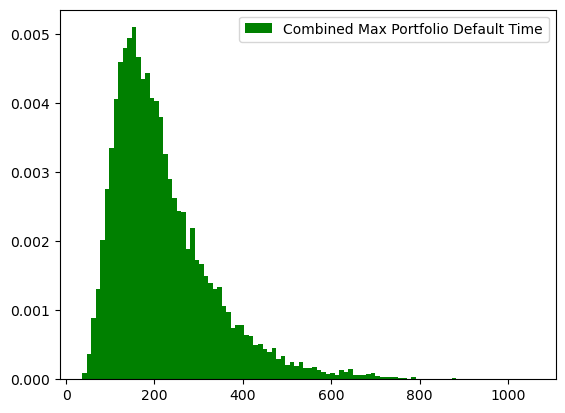

In [34]:
plt.hist(port_def_ts, bins = 100,density= True,stacked = True, label = 'Combined Max Portfolio Default Time', color= 'green')
plt.legend()
plt.show()

In [35]:
port_def_ts = []
port_def_js = []
port_def_ks = []
for i in range(sims):
    default_t = np.mean(res[0].T[i])
    default_j = np.mean(res[0].T[i][:5])
    default_k = np.mean(res[0].T[i][5:])
    port_def_ts.append(default_t)
    port_def_js.append(default_j)
    port_def_ks.append(default_k)


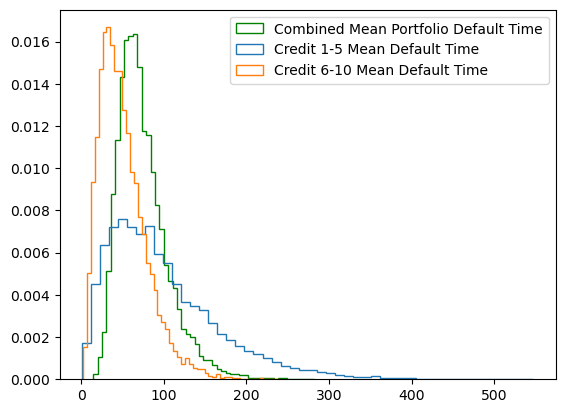

In [36]:
plt.hist(port_def_ts, bins = 50,density= True,stacked = True, histtype='step', label = 'Combined Mean Portfolio Default Time', color= 'green')
plt.hist(port_def_js, bins = 50,density= True,stacked = True, histtype='step', label = 'Credit 1-5 Mean Default Time')
plt.hist(port_def_ks, bins = 50,density= True,stacked = True, histtype='step', label = 'Credit 6-10 Mean Default Time' )
plt.legend()
plt.show()

In [37]:
#Cummulative probability mean default time is less
percent_comb_port_less_25 = np.where(port_def_ts < np.ones(sims)*25,1,0).cumsum()[-1]/sims
percent_1_port_less_25 = np.where(port_def_js < np.ones(sims)*25,1,0).cumsum()[-1]/sims
percent_2_port_less_25 = np.where(port_def_ks < np.ones(sims)*25,1,0).cumsum()[-1]/sims
percent_comb_port_less_50 = np.where(port_def_ts < np.ones(sims)*50,1,0).cumsum()[-1]/sims
percent_1_port_less_50 = np.where(port_def_js < np.ones(sims)*50,1,0).cumsum()[-1]/sims
percent_2_port_less_50 = np.where(port_def_ks < np.ones(sims)*50,1,0).cumsum()[-1]/sims
percent_comb_port_less_75 = np.where(port_def_ts < np.ones(sims)*75,1,0).cumsum()[-1]/sims
percent_1_port_less_75 = np.where(port_def_js < np.ones(sims)*75,1,0).cumsum()[-1]/sims
percent_2_port_less_75 = np.where(port_def_ks < np.ones(sims)*75,1,0).cumsum()[-1]/sims
percent_comb_port_less_100 = np.where(port_def_ts < np.ones(sims)*100,1,0).cumsum()[-1]/sims
percent_1_port_less_100 = np.where(port_def_js < np.ones(sims)*100,1,0).cumsum()[-1]/sims
percent_2_port_less_100 = np.where(port_def_ks < np.ones(sims)*100,1,0).cumsum()[-1]/sims
percent_comb_port_less_125 = np.where(port_def_ts < np.ones(sims)*125,1,0).cumsum()[-1]/sims
percent_1_port_less_125 = np.where(port_def_js < np.ones(sims)*125,1,0).cumsum()[-1]/sims
percent_2_port_less_125 = np.where(port_def_ks < np.ones(sims)*125,1,0).cumsum()[-1]/sims
percent_comb_port_less_150 = np.where(port_def_ts < np.ones(sims)*150,1,0).cumsum()[-1]/sims
percent_1_port_less_150 = np.where(port_def_js < np.ones(sims)*150,1,0).cumsum()[-1]/sims
percent_2_port_less_150 = np.where(port_def_ks < np.ones(sims)*150,1,0).cumsum()[-1]/sims
percent_comb_port_less_175 = np.where(port_def_ts < np.ones(sims)*175,1,0).cumsum()[-1]/sims
percent_1_port_less_175 = np.where(port_def_js < np.ones(sims)*175,1,0).cumsum()[-1]/sims
percent_2_port_less_175 = np.where(port_def_ks < np.ones(sims)*175,1,0).cumsum()[-1]/sims
percent_comb_port_less_200 = np.where(port_def_ts < np.ones(sims)*200,1,0).cumsum()[-1]/sims
percent_1_port_less_200 = np.where(port_def_js < np.ones(sims)*200,1,0).cumsum()[-1]/sims
percent_2_port_less_200 = np.where(port_def_ks < np.ones(sims)*200,1,0).cumsum()[-1]/sims
percent_comb_port_less_250 = np.where(port_def_ts < np.ones(sims)*250,1,0).cumsum()[-1]/sims
percent_1_port_less_250 = np.where(port_def_js < np.ones(sims)*250,1,0).cumsum()[-1]/sims
percent_2_port_less_250 = np.where(port_def_ks < np.ones(sims)*250,1,0).cumsum()[-1]/sims
percent_comb_port_less_300 = np.where(port_def_ts < np.ones(sims)*300,1,0).cumsum()[-1]/sims
percent_1_port_less_300 = np.where(port_def_js < np.ones(sims)*300,1,0).cumsum()[-1]/sims
percent_2_port_less_300 = np.where(port_def_ks < np.ones(sims)*300,1,0).cumsum()[-1]/sims


In [38]:
import pandas as pd
#Minimum time to default cummulative probabilities
d = {'Cum Prob mean DT less than 25': [percent_comb_port_less_25, percent_1_port_less_25, percent_2_port_less_25], 
     'Cum Prob mean DT less than 50': [percent_comb_port_less_50, percent_1_port_less_50, percent_2_port_less_50], 
     'Cum Prob mean DT less than 75': [percent_comb_port_less_75, percent_1_port_less_75, percent_2_port_less_75], 
     'Cum Prob mean DT less than 100': [percent_comb_port_less_100, percent_1_port_less_100, percent_2_port_less_100], 
     'Cum Prob mean DT less than 125': [percent_comb_port_less_125, percent_1_port_less_125, percent_2_port_less_125], 
     'Cum Prob mean DT less than 150': [percent_comb_port_less_150, percent_1_port_less_150, percent_2_port_less_150],
     'Cum Prob mean DT less than 175': [percent_comb_port_less_175, percent_1_port_less_175, percent_2_port_less_175], 
     'Cum Prob mean DT less than 200': [percent_comb_port_less_200, percent_1_port_less_200, percent_2_port_less_200],
     'Cum Prob mean DT less than 250': [percent_comb_port_less_250, percent_1_port_less_250, percent_2_port_less_250],
     'Cum Prob mean DT less than 300': [percent_comb_port_less_300, percent_1_port_less_300, percent_2_port_less_300]
    }
table = pd.DataFrame(d, index=['Combined', 'Credits 1-5','Credits 6-10'])
table

,Cum Prob mean DT less than 25,Cum Prob mean DT less than 50,Cum Prob mean DT less than 75,Cum Prob mean DT less than 100,Cum Prob mean DT less than 125,Cum Prob mean DT less than 150,Cum Prob mean DT less than 175,Cum Prob mean DT less than 200,Cum Prob mean DT less than 250,Cum Prob mean DT less than 300
Combined,0.0067,0.2009,0.5914,0.8285,0.9322,0.9750,0.9907,0.9968,0.9996,1.0000
Credits 1-5,0.0797,0.2554,0.4342,0.6013,0.7205,0.8091,0.8720,0.9148,0.9643,0.9858
Credits 6-10,0.1888,0.5769,0.8263,0.9409,0.9781,0.9940,0.9978,0.9995,1.0000,1.0000


In [39]:
port_def_ts = []
port_def_js = []
port_def_ks = []
for i in range(sims):
    default_t = np.min(res[0].T[i])
    default_j = np.min(res[0].T[i][:5])
    default_k = np.min(res[0].T[i][5:])
    port_def_ts.append(default_t)
    port_def_js.append(default_j)
    port_def_ks.append(default_k)


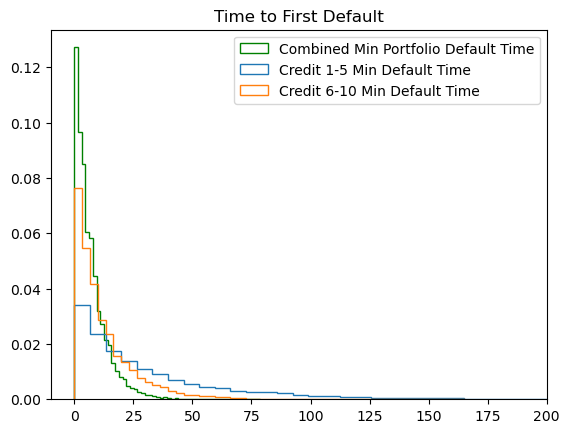

In [40]:
plt.hist(port_def_ts, bins = 50,density= True,stacked = True, histtype='step', label = 'Combined Min Portfolio Default Time', color= 'green')
plt.hist(port_def_js, bins = 50,density= True,stacked = True, histtype='step', label = 'Credit 1-5 Min Default Time')
plt.hist(port_def_ks, bins = 50,density= True,stacked = True, histtype='step', label = 'Credit 6-10 Min Default Time' )
plt.legend()
plt.title('Time to First Default')
plt.xlim(-10,200)
plt.show()

In [41]:
#Cummulative probability time to first default is less
percent_comb_port_less_5 = np.where(port_def_ts < np.ones(sims)*5,1,0).cumsum()[-1]/sims
percent_1_port_less_5 = np.where(port_def_js < np.ones(sims)*5,1,0).cumsum()[-1]/sims
percent_2_port_less_5 = np.where(port_def_ks < np.ones(sims)*5,1,0).cumsum()[-1]/sims
percent_comb_port_less_10 = np.where(port_def_ts < np.ones(sims)*10,1,0).cumsum()[-1]/sims
percent_1_port_less_10 = np.where(port_def_js < np.ones(sims)*10,1,0).cumsum()[-1]/sims
percent_2_port_less_10 = np.where(port_def_ks < np.ones(sims)*10,1,0).cumsum()[-1]/sims
percent_comb_port_less_15 = np.where(port_def_ts < np.ones(sims)*15,1,0).cumsum()[-1]/sims
percent_1_port_less_15 = np.where(port_def_js < np.ones(sims)*15,1,0).cumsum()[-1]/sims
percent_2_port_less_15 = np.where(port_def_ks < np.ones(sims)*15,1,0).cumsum()[-1]/sims
percent_comb_port_less_20 = np.where(port_def_ts < np.ones(sims)*20,1,0).cumsum()[-1]/sims
percent_1_port_less_20 = np.where(port_def_js < np.ones(sims)*20,1,0).cumsum()[-1]/sims
percent_2_port_less_20 = np.where(port_def_ks < np.ones(sims)*20,1,0).cumsum()[-1]/sims
percent_comb_port_less_25 = np.where(port_def_ts < np.ones(sims)*25,1,0).cumsum()[-1]/sims
percent_1_port_less_25 = np.where(port_def_js < np.ones(sims)*25,1,0).cumsum()[-1]/sims
percent_2_port_less_25 = np.where(port_def_ks < np.ones(sims)*25,1,0).cumsum()[-1]/sims
percent_comb_port_less_30 = np.where(port_def_ts < np.ones(sims)*30,1,0).cumsum()[-1]/sims
percent_1_port_less_30 = np.where(port_def_js < np.ones(sims)*30,1,0).cumsum()[-1]/sims
percent_2_port_less_30 = np.where(port_def_ks < np.ones(sims)*30,1,0).cumsum()[-1]/sims
percent_comb_port_less_35 = np.where(port_def_ts < np.ones(sims)*35,1,0).cumsum()[-1]/sims
percent_1_port_less_35 = np.where(port_def_js < np.ones(sims)*35,1,0).cumsum()[-1]/sims
percent_2_port_less_35 = np.where(port_def_ks < np.ones(sims)*35,1,0).cumsum()[-1]/sims
percent_comb_port_less_40 = np.where(port_def_ts < np.ones(sims)*40,1,0).cumsum()[-1]/sims
percent_1_port_less_40 = np.where(port_def_js < np.ones(sims)*40,1,0).cumsum()[-1]/sims
percent_2_port_less_40 = np.where(port_def_ks < np.ones(sims)*40,1,0).cumsum()[-1]/sims
percent_comb_port_less_50 = np.where(port_def_ts < np.ones(sims)*50,1,0).cumsum()[-1]/sims
percent_1_port_less_50 = np.where(port_def_js < np.ones(sims)*50,1,0).cumsum()[-1]/sims
percent_2_port_less_50 = np.where(port_def_ks < np.ones(sims)*50,1,0).cumsum()[-1]/sims
percent_comb_port_less_60 = np.where(port_def_ts < np.ones(sims)*60,1,0).cumsum()[-1]/sims
percent_1_port_less_60 = np.where(port_def_js < np.ones(sims)*60,1,0).cumsum()[-1]/sims
percent_2_port_less_60 = np.where(port_def_ks < np.ones(sims)*60,1,0).cumsum()[-1]/sims
percent_comb_port_less_70 = np.where(port_def_ts < np.ones(sims)*70,1,0).cumsum()[-1]/sims
percent_1_port_less_70 = np.where(port_def_js < np.ones(sims)*70,1,0).cumsum()[-1]/sims
percent_2_port_less_70 = np.where(port_def_ks < np.ones(sims)*70,1,0).cumsum()[-1]/sims

In [42]:
import pandas as pd
#Minimum time to default cummulative probabilities
d = {'Cum Prob first DT less than 5': [percent_comb_port_less_5, percent_1_port_less_5, percent_2_port_less_5], 
     'Cum Prob first DT less than 10': [percent_comb_port_less_10, percent_1_port_less_10, percent_2_port_less_10], 
     'Cum Prob first DT less than 15': [percent_comb_port_less_15, percent_1_port_less_15, percent_2_port_less_15], 
     'Cum Prob first DT less than 20': [percent_comb_port_less_20, percent_1_port_less_20, percent_2_port_less_20], 
     'Cum Prob first DT less than 25': [percent_comb_port_less_25, percent_1_port_less_25, percent_2_port_less_25], 
     'Cum Prob first DT less than 30': [percent_comb_port_less_30, percent_1_port_less_30, percent_2_port_less_30],
     'Cum Prob first DT less than 35': [percent_comb_port_less_35, percent_1_port_less_35, percent_2_port_less_35], 
     'Cum Prob first DT less than 40': [percent_comb_port_less_40, percent_1_port_less_40, percent_2_port_less_40],
     'Cum Prob first DT less than 50': [percent_comb_port_less_50, percent_1_port_less_50, percent_2_port_less_50],
     'Cum Prob first DT less than 60': [percent_comb_port_less_60, percent_1_port_less_60, percent_2_port_less_60],
     'Cum Prob first DT less than 70': [percent_comb_port_less_70, percent_1_port_less_70, percent_2_port_less_70]
    }
table = pd.DataFrame(d, index=['Combined', 'Credits 1-5','Credits 6-10'])
table

,Cum Prob first DT less than 5,Cum Prob first DT less than 10,Cum Prob first DT less than 15,Cum Prob first DT less than 20,Cum Prob first DT less than 25,Cum Prob first DT less than 30,Cum Prob first DT less than 35,Cum Prob first DT less than 40,Cum Prob first DT less than 50,Cum Prob first DT less than 60,Cum Prob first DT less than 70
Combined,0.5018,0.7621,0.8872,0.9450,0.9735,0.9871,0.9940,0.9973,0.9989,0.9997,0.9998
Credits 1-5,0.1832,0.3119,0.4157,0.4981,0.5682,0.6284,0.6780,0.7212,0.7871,0.8351,0.8727
Credits 6-10,0.3520,0.5735,0.7107,0.7972,0.8589,0.9003,0.9299,0.9523,0.9757,0.9873,0.9946
